# Main Code

In [1]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('en_core_web_sm')

with open('brennu-njals_saga_en.txt', 'r') as file:
    text = file.read()

In [3]:
doc = nlp(text)

In [4]:
def choose_relationship(node1,token,dif,relationship,dependancy):
    difference = abs(node1.i - token[1])
    if difference < dif:
        relationship = token[0]
        dependancy = token[2]
        dif = difference
    return relationship,dependancy,dif

In [14]:
def create_full_graph(doc, style):
    graph = nx.Graph()
    
    for entity in doc.ents:
        if entity.label_ == 'PERSON':
            graph.add_node(entity.text)

    if style == "relationship":
        # Iterate over the sentences and extract the connections between characters
        for sent in doc.sents:
            sent_ents = [ent.text for ent in sent.ents if ent.label_ == 'PERSON']
            for i in range(len(sent_ents)):
                for j in range(i + 1, len(sent_ents)):
                    node1 = sent_ents[i]
                    node2 = sent_ents[j]
                    
                    node1_token = None
                    node2_token = None

                    # Find the tokens corresponding to node1 and node2
                    for token in sent:
                        if token.text == node1.split()[0]:
                            node1_token = token
                        if token.text == node2.split()[0]:
                            node2_token = token
                        if node1_token and node2_token:
                            break
                    
                    if graph.has_edge(node1, node2):
                        # Increment the weight of the edge if it already exists
                        graph[node1][node2]['weight'] += 1
                    else:
                        # Add a new edge with weight 1 if it doesn't exist
                        graph.add_edge(node1, node2, weight=1)

                    # Extract the relationship between the characters from the sentence
                    relationship = ''
                    dependancy = ''
                    sent_token=[]

                    for token in sent:
                        if  ((token.dep_ == 'attr'and token.text == 'son') or
                            (token.dep_ == 'nsubj'and token.pos_ == 'NOUN') or
                            (token.dep_ == 'poss'and token.pos_ == 'NOUN') or
                            (token.dep_ == 'conj'and token.pos_ == 'NOUN') or
                            (token.dep_ == 'appos'and token.pos_ == 'NOUN')):
                            sent_token.append([token.text,token.i,token.dep_])
                    
                    if (node1_token != None) & (node2_token != None):
                        dif = 100
                        for k in sent_token:
                            if (k[1] > node1_token.i) & (k[1] < node2_token.i):
                                relationship, dependancy, dif = choose_relationship(node1_token,k,dif,relationship,dependancy)
                        
                        dif = 100
                        if relationship == "":
                            for k in sent_token:
                                relationship, dependancy, dif = choose_relationship(node1_token,k,dif,relationship,dependancy)

                    # Assign the relationship name as an edge attribute
                    graph[node1][node2]['relationship'] = relationship
        
    elif style == "weight":
        for sentence in doc.sents:
            sentence_characters = []

            for entity in sentence.ents:
                if entity.label_ == 'PERSON':
                    sentence_characters.append(entity.text)

            for i, character1 in enumerate(sentence_characters):
                for character2 in sentence_characters[i + 1:]:
                    if graph.has_edge(character1, character2):
                        graph[character1][character2]['weight'] += 1
                    else:
                        graph.add_edge(character1, character2, weight=1)

        # Get a list of nodes without edges
        isolated_nodes = [node for node, degree in dict(graph.degree()).items() if degree == 0]
        graph.remove_nodes_from(isolated_nodes)

    return graph

In [25]:
def create_subgraph(graph, chosen_person):
    # Get the neighbors of the chosen_person
    neighbors = list(graph.neighbors(chosen_person))
    neighbors.append(chosen_person)
    
    subgraph = graph.subgraph(neighbors)

    node_colors = ['#6fa8dc' if node != chosen_person else 'red' for node in subgraph.nodes]

    return subgraph, node_colors

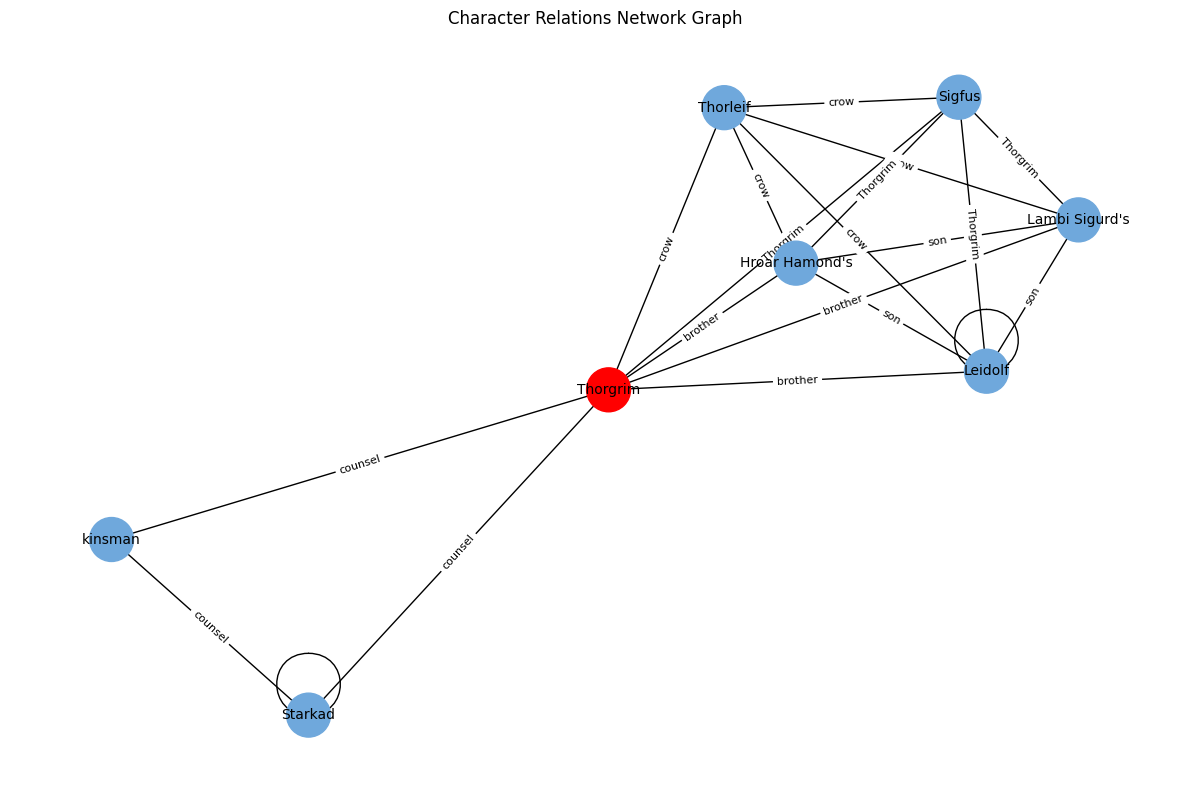

In [43]:
chosen_person = "Thorgrim"
style = "relationship"

full_graph = create_full_graph(doc, style)

subgraph,node_colors = create_subgraph(full_graph, chosen_person)

pos = nx.spring_layout(subgraph, seed=0)  # Adjust layout algorithm as needed

if style == "weight":
    # Get edge weights
    edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

    # Normalize the edge weights to be within a specific range
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    edge_weights_normalized = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

    edge_widths = [1 + 3 * weight for weight in edge_weights_normalized]
else:   
    edge_widths = 1

plt.figure(figsize=(12, 8))
nx.draw_networkx(subgraph, pos, with_labels=True, node_size=1000, font_size=10,width=edge_widths, node_color=node_colors)
edge_labels = nx.get_edge_attributes(subgraph, style)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
plt.title('Character Relations Network Graph')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'graphs/{chosen_person}_{style}.png')

# Find the nodes with the most neighbours 

In [9]:
edge_count = {}
edge_contents = {}
for node in G.nodes():
    neighbors = G.neighbors(node)
    count = 0
    contents = []
    for neighbor in neighbors:
        edge_data = G.get_edge_data(node, neighbor)
        if edge_data:
            count += 1
            contents.append(edge_data['relationship'])
    edge_count[node] = count
    edge_contents[node] = contents

sorted_nodes = sorted(edge_count, key=edge_count.get, reverse=True)

N = 75  # Number of nodes to retrieve

highest_nodes = sorted_nodes[:N]

print("Nodes with the most edges connecting neighboring nodes:")
for node in highest_nodes:
    print(f"Node {node}: Edge Count = {edge_count[node]}")
    print("Edge Contents:", edge_contents[node])
    print()


Nodes with the most edges connecting neighboring nodes:
Node Kari: Edge Count = 69
Edge Contents: ['', 'sword', 'end', 'man', '', 'man', 'slaying', 'trial', '', '', '', '', 'thou', 'sons', 'daring', '', 'end', 'east', '', '', 'son', 'father', 'son', 'ye', '', 'children', '', 'purpose', 'men', '', 'son', 'part', 'shalt', 'son', '', 'bargain', 'bargain', 'chiefs', 'son', 'bone', 'bone', '', '', 'son', '', 'son', 'son', '', '', 'atonement', 'son', 'son', 'men', '', '', 'housewife', 'son', 'sword', 'sword', 'others', 'son', 'Chapter', 'son', 'blow', '', 'son', 'black', 'black', 'priest']

Node Gunnar: Edge Count = 61
Edge Contents: ['', 'Arnguda', '', '', 'men', '', '', 'man', '', 'shepherd', 'swords', 'eye', '', 'son', 'spring', 'ship', 'priest', 'man', 'sons', 'sons', 'end', 'wife', 'son', 'matter', '', 'shalt', 'thou', 'slaying', '', 'doest', 'son', '', 'priest', '', '', 'shalt', 'canst', '', '', 'attack', 'thing', '', 'son', 'hand', '', 'kinsman', 'sword', '', 'messmate', 'outlaws', 's